In [2]:
# Importing few libraries
import os
import shutil
import random
from tqdm import tqdm

import numpy as np
import pandas as pd

import PIL
import matplotlib.pyplot as plt

**Data Exploration**

In [2]:
DATASET = "/kaggle/input/eurosat-rgb/2750"

LABELS = os.listdir(DATASET)
print(LABELS)

['SeaLake', 'Highway', 'River', 'Pasture', 'Industrial', 'Residential', 'PermanentCrop', 'AnnualCrop', 'Forest', 'HerbaceousVegetation']


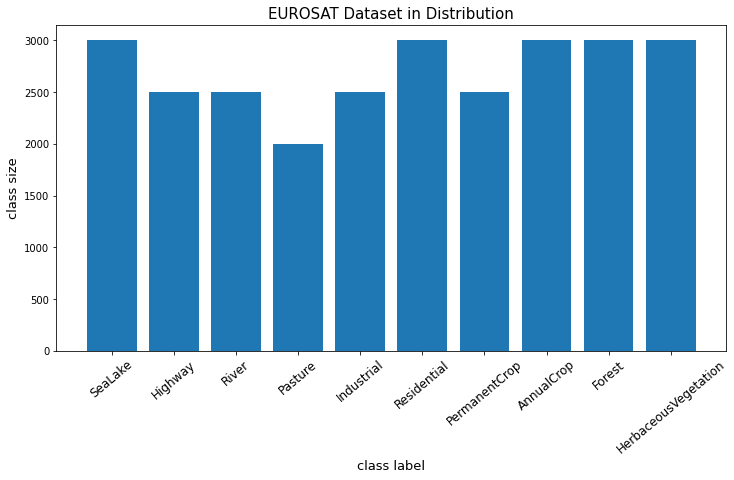

In [3]:
# plotting class distributions of whole dataset
counts = {}

for l in LABELS:
    counts[l] = len(os.listdir(os.path.join(DATASET, l)))

    
plt.figure(figsize=(12, 6))

plt.bar(range(len(counts)), list(counts.values()), align='center')
plt.xticks(range(len(counts)), list(counts.keys()), fontsize=12, rotation=40)
plt.xlabel('class label', fontsize=13)
plt.ylabel('class size', fontsize=13)
plt.title('EUROSAT Dataset in Distribution', fontsize=15);

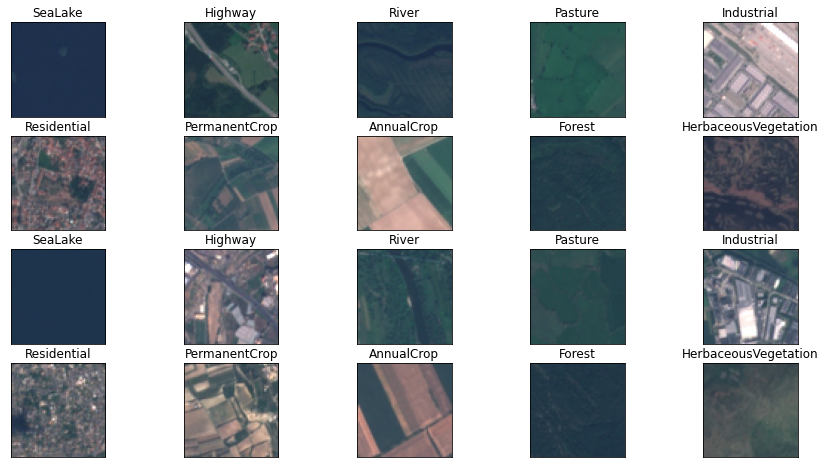

In [4]:
img_paths = [os.path.join(DATASET, l, l+'_1000.jpg') for l in LABELS]

img_paths = img_paths + [os.path.join(DATASET, l, l+'_2000.jpg') for l in LABELS]

def plot_sat_imgs(paths):
    plt.figure(figsize=(15, 8))
    for i in range(20):
        plt.subplot(4, 5, i+1, xticks=[], yticks=[])
        img = PIL.Image.open(paths[i], 'r')
        plt.imshow(np.asarray(img))
        plt.title(paths[i].split('/')[-2])

plot_sat_imgs(img_paths)

**Preprocessing**

In [5]:
import re
from sklearn.model_selection import StratifiedShuffleSplit
from keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = '/kaggle/working/training'
TEST_DIR = '/kaggle/working/testing'
BATCH_SIZE = 64
NUM_CLASSES=len(LABELS)
INPUT_SHAPE = (64, 64, 3)
CLASS_MODE = 'categorical'

# creating training and testing directories
for path in (TRAIN_DIR, TEST_DIR):
    if not os.path.exists(path):
        os.mkdir(path)

# creating class label subdirectories in train and test
for l in LABELS:
    
    if not os.path.exists(os.path.join(TRAIN_DIR, l)):
        os.mkdir(os.path.join(TRAIN_DIR, l))

    if not os.path.exists(os.path.join(TEST_DIR, l)):
        os.mkdir(os.path.join(TEST_DIR, l))

In [6]:
# mapping each image path to their class label in 'data'
data = {}

for l in LABELS:
    for img in os.listdir(DATASET+'/'+l):
        data.update({os.path.join(DATASET, l, img): l})

X = pd.Series(list(data.keys()))
y = pd.get_dummies(pd.Series(data.values()))

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=69)

# spliting the list of image paths
for train_idx, test_idx in split.split(X, y):
    
    train_paths = X[train_idx]
    test_paths = X[test_idx]
    
    # define a new path for each image depending on training or testing
    new_train_paths = [re.sub('\/kaggle\/input\/eurosat-rgb\/2750', '/kaggle/working/training', i) for i in train_paths]
    new_test_paths = [re.sub('\/kaggle\/input\/eurosat-rgb\/2750', '/kaggle/working/testing', i) for i in test_paths]

    train_path_map = list((zip(train_paths, new_train_paths)))
    test_path_map = list((zip(test_paths, new_test_paths)))
    
    # moving the files
    print("moving training files..")
    for i in tqdm(train_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('training', 'testing', i[1])):
                shutil.copy(i[0], i[1])
    
    print("moving testing files..")
    for i in tqdm(test_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('training', 'testing', i[1])):
                shutil.copy(i[0], i[1])

moving training files..


100%|██████████| 21600/21600 [03:10<00:00, 113.27it/s]


moving testing files..


100%|██████████| 5400/5400 [00:45<00:00, 117.91it/s]


In [7]:
# Creating a ImageDataGenerator Instance which can be used for data augmentation

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip = True

)

train_generator = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=True,
    seed=70
)

# test generator for evaluation purposes with no augmentations, just rescaling
test_gen = ImageDataGenerator(
    rescale=1./255,
)

test_generator = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=False,
    seed=70
)

Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


In [8]:
print(train_generator.class_indices)

{'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


In [9]:
np.save('class_indices', train_generator.class_indices)

**Deep Learning Start**

In [10]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.applications import ResNet50, ResNet50V2

from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, fbeta_score, accuracy_score

In [12]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")    
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)
    
tf.config.set_soft_device_placement(True)

1 Physical GPUs, 1 Logical GPU


In [13]:
# For different CNN models we are using different setup of dense layers
def compile_model(cnn_base, input_shape, n_classes, optimizer, fine_tune=None):
    
    if (cnn_base == 'ResNet50') or (cnn_base == 'ResNet50V2'):
        if cnn_base == 'ResNet50':
            conv_base = ResNet50(include_top=False,
                                 weights='imagenet', 
                                 input_shape=input_shape)
        else:
            conv_base = ResNet50V2(include_top=False,
                                 weights='imagenet', 
                                 input_shape=input_shape)
        top_model = conv_base.output
        top_model = Flatten()(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = Dropout(0.2)(top_model)
       
    
    elif (cnn_base == 'VGG16') or (cnn_base == 'VGG19'):
        if cnn_base == 'VGG16':
            conv_base = VGG16(include_top=False,
                              weights='imagenet', 
                              input_shape=input_shape)
        else:
            conv_base = VGG19(include_top=False,
                              weights='imagenet', 
                              input_shape=input_shape)
        top_model = conv_base.output
        top_model = Flatten()(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = Dropout(0.2)(top_model)
        
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = Dropout(0.2)(top_model)
    
    
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    model = Model(inputs=conv_base.input, outputs=output_layer)
        
    if type(fine_tune) == int:
        for layer in conv_base.layers[fine_tune:]:
            layer.trainable = True
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    model.compile(optimizer=optimizer, loss='categorical_crossentropy',
                 metrics=['categorical_accuracy'])
    
    return model

In [1]:
def plot_history(history):
       
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc)
    plt.plot(val_acc)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(loss)
    plt.plot(val_loss)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.show();

In [30]:
def save_result(cnn_base, history):
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    if cnn_base == 'ResNet50':
        
        acc_ResNet50 = np.array(acc)
        val_acc_ResNet50 = np.array(val_acc)
        loss_ResNet50 = np.array(loss)
        val_loss_ResNet50 = np.array(val_loss)

        np.save('acc_ResNet50.npy', acc_ResNet50)
        np.save('val_acc_ResNet50.npy', val_acc_ResNet50)
        np.save('loss_ResNet50.npy', loss_ResNet50)
        np.save('val_loss_ResNet50.npy', val_loss_ResNet50)

    elif cnn_base == 'ResNet50V2':
        
        acc_ResNet50V2 = np.array(acc)
        val_acc_ResNet50V2 = np.array(val_acc)
        loss_ResNet50V2 = np.array(loss)
        val_loss_ResNet50V2 = np.array(val_loss)

        np.save('acc_ResNet50V2.npy', acc_ResNet50V2)
        np.save('val_acc_ResNet50V2.npy', val_acc_ResNet50V2)
        np.save('loss_ResNet50V2.npy', loss_ResNet50V2)
        np.save('val_loss_ResNet50V2.npy', val_loss_ResNet50V2)


    elif cnn_base == 'VGG16':
        
        acc_VGG16 = np.array(acc)
        val_acc_VGG16 = np.array(val_acc)
        loss_VGG16 = np.array(loss)
        val_loss_VGG16 = np.array(val_loss)

        np.save('acc_VGG16.npy', acc_VGG16)
        np.save('val_acc_VGG16.npy', val_acc_VGG16)
        np.save('loss_VGG16.npy', loss_VGG16)
        np.save('val_loss_VGG16.npy', val_loss_VGG16)

    elif cnn_base == 'VGG19':
        
        acc_VGG19 = np.array(acc)
        val_acc_VGG19 = np.array(val_acc)
        loss_VGG19 = np.array(loss)
        val_loss_VGG19 = np.array(val_loss)

        np.save('acc_VGG19.npy', acc_VGG19)
        np.save('val_acc_VGG19.npy', val_acc_VGG19)
        np.save('loss_VGG19.npy', loss_VGG19)
        np.save('val_loss_VGG19.npy', val_loss_VGG19)

In [16]:
def display_results(y_true, y_preds, class_labels):
    
    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                          columns=class_labels).T
    results.rename(columns={0: 'Precision',
                           1: 'Recall',
                           2: 'F-Score',
                           3: 'Support'}, inplace=True)
    
    conf_mat = pd.DataFrame(confusion_matrix(y_true, y_preds), 
                            columns=class_labels,
                            index=class_labels)    
    f2 = fbeta_score(y_true, y_preds, beta=2, average='micro')
    accuracy = accuracy_score(y_true, y_preds)
    print(f"Accuracy: {accuracy}")
    print(f"Global F2 Score: {f2}")    
    return results, conf_mat

In [17]:
def plot_predictions(y_true, y_preds, test_generator, class_indices):

    fig = plt.figure(figsize=(20, 10))
    for i, idx in enumerate(np.random.choice(test_generator.samples, size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx]))
        pred_idx = np.argmax(y_preds[idx])
        true_idx = y_true[idx]
                
        plt.tight_layout()
        ax.set_title("{}\n({})".format(class_indices[pred_idx], class_indices[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

In [18]:
N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 100

# model callbacks
checkpoint = ModelCheckpoint(filepath='../working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

**1. ResNet50 Model**

In [19]:
resnet50_model = compile_model('ResNet50', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-2), fine_tune=None)
resnet50_model.summary()

94781440/94765736 [==============================] - 4s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
_____________________________

In [21]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 100

# model callbacks
checkpoint = ModelCheckpoint(filepath='../working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

In [23]:
# First Pretraining the dense layer
resnet50_history = resnet50_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=50,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/50
337/337 [==============================] - 41s 122ms/step - loss: 2.0155 - categorical_accuracy: 0.2134 - val_loss: 1.7615 - val_categorical_accuracy: 0.3218

Epoch 00001: val_categorical_accuracy improved from -inf to 0.32180, saving model to ../working/model.weights.best.hdf5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
337/337 [==============================] - 40s 119ms/step - loss: 1.9005 - categorical_accuracy: 0.2490 - val_loss: 1.7844 - val_categorical_accuracy: 0.3065

Epoch 00002: val_categorical_accuracy did not improve from 0.32180
Epoch 3/50
337/337 [==============================] - 40s 118ms/step - loss: 1.8689 - categorical_accuracy: 0.2609 - val_loss: 1.6720 - val_categorical_accuracy: 0.3371

Epoch 00003: val_categorical_accuracy improved from 0.32180 to 0.33705, saving model to ../working/model.weights.best.hdf5
Epoch 4/50
337/337 [==============================] - 40s 117ms/step - loss: 1.8490 - categorical_accuracy: 0.2667 - val_loss: 1.6981 - val_categorical_accuracy: 0.3049

Epoch 00004: val_categorical_accuracy did not improve from 0.33705
Epoch 5/50
337/337 [==============================] - 39s 117ms/step - loss: 1.8596 - categorical_accuracy: 0.2718 - val_loss: 1.6707 - val_categorical_accuracy: 0.3229

Epoch 00005: val_categorical_accuracy did not improve from 0.33

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f8b1a732320>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


337/337 [==============================] - 40s 118ms/step - loss: 1.8115 - categorical_accuracy: 0.2903 - val_loss: 1.6648 - val_categorical_accuracy: 0.3534

Epoch 00007: val_categorical_accuracy improved from 0.34524 to 0.35342, saving model to ../working/model.weights.best.hdf5
Epoch 8/50
337/337 [==============================] - 40s 118ms/step - loss: 1.8231 - categorical_accuracy: 0.2912 - val_loss: 1.7013 - val_categorical_accuracy: 0.3570

Epoch 00008: val_categorical_accuracy improved from 0.35342 to 0.35696, saving model to ../working/model.weights.best.hdf5
Epoch 9/50
337/337 [==============================] - 40s 119ms/step - loss: 1.8285 - categorical_accuracy: 0.2878 - val_loss: 1.6936 - val_categorical_accuracy: 0.3078

Epoch 00009: val_categorical_accuracy did not improve from 0.35696
Epoch 10/50
337/337 [==============================] - 40s 117ms/step - loss: 1.8030 - categorical_accuracy: 0.2970 - val_loss: 1.6577 - val_categorical_accuracy: 0.3850

Epoch 00010: val_

In [24]:
# re-training whole network end2end 
resnet50_model = compile_model('ResNet50', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-4), fine_tune=0)

resnet50_model.load_weights('../working/model.weights.best.hdf5')

train_generator.reset()
test_generator.reset()

resnet50_history = resnet50_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/100
337/337 [==============================] - 51s 136ms/step - loss: 1.7848 - categorical_accuracy: 0.7581 - val_loss: 224.1145 - val_categorical_accuracy: 0.0926

Epoch 00001: val_categorical_accuracy did not improve from 0.41071
Epoch 2/100
337/337 [==============================] - 46s 136ms/step - loss: 0.3702 - categorical_accuracy: 0.8792 - val_loss: 210.9644 - val_categorical_accuracy: 0.0831

Epoch 00002: val_categorical_accuracy did not improve from 0.41071
Epoch 3/100
337/337 [==============================] - 46s 136ms/step - loss: 0.2910 - categorical_accuracy: 0.9025 - val_loss: 1.2638 - val_categorical_accuracy: 0.6484

Epoch 00003: val_categorical_accuracy improved from 0.41071 to 0.64844, saving model to ../working/model.weights.best.hdf5
Epoch 4/100
337/337 [==============================] - 46s 135ms/step - loss: 0.2328 - categorical_accuracy: 0.9212 - val_loss: 0.2645 - val_categorical_accuracy: 0.9262

Epoch 00004: val_categorical_accuracy improved from 0.6

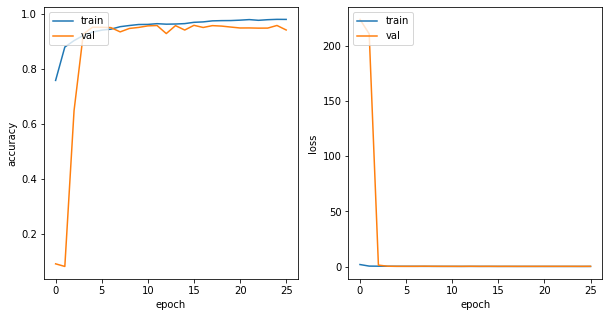

In [29]:
plot_history(resnet50_history)

In [39]:
resnet50_model.load_weights('../working/model.weights.best.hdf5')

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=70
)

predictions = resnet50_model.predict(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 5400 images belonging to 10 classes.
Accuracy: 0.9575925925925926
Global F2 Score: 0.9575925925925926


,Precision,Recall,F-Score,Support
AnnualCrop,0.960616,0.935000,0.947635,600.0
Forest,0.921659,1.000000,0.959233,600.0
HerbaceousVegetation,0.947020,0.953333,0.950166,600.0
Highway,0.974948,0.934000,0.954035,500.0
Industrial,0.979381,0.950000,0.964467,500.0
Pasture,0.988920,0.892500,0.938239,400.0
PermanentCrop,0.931452,0.924000,0.927711,500.0
Residential,0.946372,1.000000,0.972447,600.0
River,0.945736,0.976000,0.960630,500.0
SeaLake,0.998305,0.981667,0.989916,600.0


In [40]:
conf_mat

,AnnualCrop,Forest,HerbaceousVegetation,Highway,Industrial,Pasture,PermanentCrop,Residential,River,SeaLake
AnnualCrop,561,4,3,1,0,3,23,0,4,1
Forest,0,600,0,0,0,0,0,0,0,0
HerbaceousVegetation,1,18,572,0,0,0,7,2,0,0
Highway,5,0,3,467,3,0,3,3,16,0
Industrial,1,0,0,2,475,0,0,22,0,0
Pasture,8,20,9,0,0,357,1,0,5,0
PermanentCrop,7,0,17,2,6,1,462,5,0,0
Residential,0,0,0,0,0,0,0,600,0,0
River,1,1,0,7,1,0,0,2,488,0
SeaLake,0,8,0,0,0,0,0,0,3,589


In [42]:
# Saving the model and the weights
resnet50_model.save('../working/ResNet50_eurosat.h5')

In [51]:
# Saving the results of this model
save_result('ResNet50', resnet50_history)

**2. ResNet50V2 Model**

In [19]:
resnet50V2_model = compile_model('ResNet50V2', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-2), fine_tune=None)
resnet50V2_model.summary()

94683136/94668760 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 34, 34, 64)   0           conv1_conv[0][0]                 
_____________________________

In [20]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 100

# model callbacks
checkpoint = ModelCheckpoint(filepath='../working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

In [22]:
# First Pretraining the dense layer
resnet50V2_history = resnet50V2_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=50,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/50
337/337 [==============================] - 41s 120ms/step - loss: 1.8845 - categorical_accuracy: 0.6571 - val_loss: 0.9086 - val_categorical_accuracy: 0.7493

Epoch 00001: val_categorical_accuracy improved from -inf to 0.74926, saving model to ../working/model.weights.best.hdf5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
337/337 [==============================] - 40s 119ms/step - loss: 1.1491 - categorical_accuracy: 0.6920 - val_loss: 0.8751 - val_categorical_accuracy: 0.7669

Epoch 00002: val_categorical_accuracy improved from 0.74926 to 0.76693, saving model to ../working/model.weights.best.hdf5
Epoch 3/50
337/337 [==============================] - 39s 116ms/step - loss: 1.0135 - categorical_accuracy: 0.7108 - val_loss: 0.8024 - val_categorical_accuracy: 0.7712

Epoch 00003: val_categorical_accuracy improved from 0.76693 to 0.77121, saving model to ../working/model.weights.best.hdf5
Epoch 4/50
337/337 [==============================] - 39s 117ms/step - loss: 1.0088 - categorical_accuracy: 0.7126 - val_loss: 0.8048 - val_categorical_accuracy: 0.7915

Epoch 00004: val_categorical_accuracy improved from 0.77121 to 0.79148, saving model to ../working/model.weights.best.hdf5
Epoch 5/50
337/337 [==============================] - 39s 117ms/step - loss: 0.9921 - categorical_accuracy: 0.7199 - val_

In [23]:
# re-train whole network end2end 
resnet50V2_model = compile_model('ResNet50V2', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-4), fine_tune=0)

resnet50V2_model.load_weights('../working/model.weights.best.hdf5')

train_generator.reset()
test_generator.reset()

resnet50V2_history = resnet50V2_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/100
337/337 [==============================] - 52s 137ms/step - loss: 1.4423 - categorical_accuracy: 0.6422 - val_loss: 1.0534 - val_categorical_accuracy: 0.7150

Epoch 00001: val_categorical_accuracy did not improve from 0.82812
Epoch 2/100
337/337 [==============================] - 45s 133ms/step - loss: 0.7588 - categorical_accuracy: 0.7793 - val_loss: 0.6995 - val_categorical_accuracy: 0.7956

Epoch 00002: val_categorical_accuracy did not improve from 0.82812
Epoch 3/100
337/337 [==============================] - 44s 130ms/step - loss: 0.6161 - categorical_accuracy: 0.8161 - val_loss: 0.7132 - val_categorical_accuracy: 0.8350

Epoch 00003: val_categorical_accuracy improved from 0.82812 to 0.83501, saving model to ../working/model.weights.best.hdf5
Epoch 4/100
337/337 [==============================] - 44s 129ms/step - loss: 0.5548 - categorical_accuracy: 0.8385 - val_loss: 0.4205 - val_categorical_accuracy: 0.8880

Epoch 00004: val_categorical_accuracy improved from 0.83501

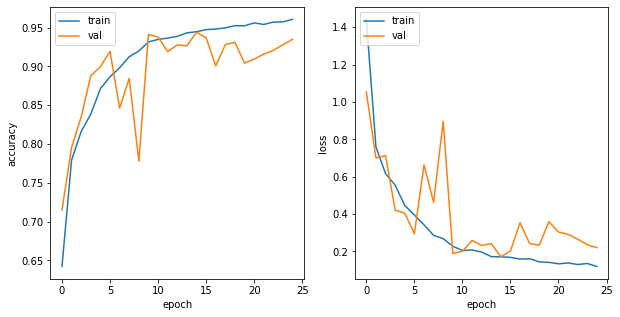

In [24]:
plot_history(resnet50V2_history)

In [25]:
resnet50V2_model.load_weights('../working/model.weights.best.hdf5')

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = resnet50V2_model.predict(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 5400 images belonging to 10 classes.
Accuracy: 0.9407407407407408
Global F2 Score: 0.9407407407407407


,Precision,Recall,F-Score,Support
AnnualCrop,0.899522,0.940000,0.919315,600.0
Forest,0.934579,1.000000,0.966184,600.0
HerbaceousVegetation,0.945518,0.896667,0.920445,600.0
Highway,0.934560,0.914000,0.924166,500.0
Industrial,0.968815,0.932000,0.950051,500.0
Pasture,0.967391,0.890000,0.927083,400.0
PermanentCrop,0.898167,0.882000,0.890010,500.0
Residential,0.920000,0.996667,0.956800,600.0
River,0.955734,0.950000,0.952859,500.0
SeaLake,0.998294,0.975000,0.986509,600.0


In [26]:
conf_mat

,AnnualCrop,Forest,HerbaceousVegetation,Highway,Industrial,Pasture,PermanentCrop,Residential,River,SeaLake
AnnualCrop,564,3,1,4,1,6,19,0,1,1
Forest,0,600,0,0,0,0,0,0,0,0
HerbaceousVegetation,11,17,538,4,0,4,17,9,0,0
Highway,11,0,2,457,4,1,9,3,13,0
Industrial,2,0,0,0,466,0,0,31,1,0
Pasture,10,16,8,1,0,356,5,0,4,0
PermanentCrop,17,0,18,6,9,0,441,9,0,0
Residential,1,0,0,0,1,0,0,598,0,0
River,6,1,1,16,0,1,0,0,475,0
SeaLake,5,5,1,1,0,0,0,0,3,585


In [28]:
# Saving the model and the weights
resnet50V2_model.save('../working/ResNet50V2_eurosat.h5')

In [31]:
# Saving the result
save_result('ResNet50V2', resnet50V2_history)

**3. VGG16 Model**

In [32]:
vgg16_model = compile_model('VGG16', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-2), fine_tune=None)
vgg16_model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
____________________________________________________________

In [33]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 100

# model callbacks
checkpoint = ModelCheckpoint(filepath='../working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

In [34]:
train_generator.reset()
# First Pretraining the dense layer
vgg16_history = vgg16_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=50,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/50
337/337 [==============================] - 42s 121ms/step - loss: 1.9757 - categorical_accuracy: 0.5567 - val_loss: 0.9301 - val_categorical_accuracy: 0.7072

Epoch 00001: val_categorical_accuracy improved from -inf to 0.70722, saving model to ../working/model.weights.best.hdf5
Epoch 2/50
337/337 [==============================] - 40s 118ms/step - loss: 1.0226 - categorical_accuracy: 0.6502 - val_loss: 0.8792 - val_categorical_accuracy: 0.6988

Epoch 00002: val_categorical_accuracy did not improve from 0.70722
Epoch 3/50
337/337 [==============================] - 39s 116ms/step - loss: 0.9702 - categorical_accuracy: 0.6705 - val_loss: 0.7112 - val_categorical_accuracy: 0.7634

Epoch 00003: val_categorical_accuracy improved from 0.70722 to 0.76339, saving model to ../working/model.weights.best.hdf5
Epoch 4/50
337/337 [==============================] - 38s 114ms/step - loss: 0.9561 - categorical_accuracy: 0.6822 - val_loss: 0.7935 - val_categorical_accuracy: 0.7511

Epoch 0000

In [35]:
# re-train whole network end2end 
vgg16_model = compile_model('VGG16', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-4), fine_tune=0)

vgg16_model.load_weights('../working/model.weights.best.hdf5')

train_generator.reset()
test_generator.reset()

vgg16_history = vgg16_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/100
337/337 [==============================] - 58s 127ms/step - loss: 1.5646 - categorical_accuracy: 0.4569 - val_loss: 0.9643 - val_categorical_accuracy: 0.6362

Epoch 00001: val_categorical_accuracy did not improve from 0.81417
Epoch 2/100
337/337 [==============================] - 43s 127ms/step - loss: 0.7591 - categorical_accuracy: 0.7587 - val_loss: 0.4496 - val_categorical_accuracy: 0.8514

Epoch 00002: val_categorical_accuracy improved from 0.81417 to 0.85138, saving model to ../working/model.weights.best.hdf5
Epoch 3/100
337/337 [==============================] - 43s 129ms/step - loss: 0.5111 - categorical_accuracy: 0.8453 - val_loss: 0.3109 - val_categorical_accuracy: 0.8997

Epoch 00003: val_categorical_accuracy improved from 0.85138 to 0.89974, saving model to ../working/model.weights.best.hdf5
Epoch 4/100
337/337 [==============================] - 43s 126ms/step - loss: 0.5189 - categorical_accuracy: 0.8486 - val_loss: 0.7006 - val_categorical_accuracy: 0.8231

Epo

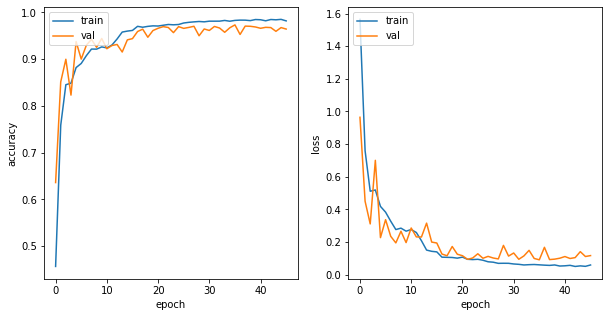

In [36]:
plot_history(vgg16_history)

In [38]:
vgg16_model.load_weights('../working/model.weights.best.hdf5')

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = vgg16_model.predict(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 5400 images belonging to 10 classes.
Accuracy: 0.9731481481481481
Global F2 Score: 0.9731481481481481


,Precision,Recall,F-Score,Support
AnnualCrop,0.963668,0.928333,0.945671,600.0
Forest,0.977199,1.000000,0.988468,600.0
HerbaceousVegetation,0.976271,0.960000,0.968067,600.0
Highway,0.979920,0.976000,0.977956,500.0
Industrial,0.989980,0.988000,0.988989,500.0
Pasture,0.965174,0.970000,0.967581,400.0
PermanentCrop,0.920543,0.950000,0.935039,500.0
Residential,0.975570,0.998333,0.986820,600.0
River,0.978218,0.988000,0.983085,500.0
SeaLake,1.000000,0.973333,0.986486,600.0


In [39]:
conf_mat

,AnnualCrop,Forest,HerbaceousVegetation,Highway,Industrial,Pasture,PermanentCrop,Residential,River,SeaLake
AnnualCrop,557,3,0,2,0,7,29,0,2,0
Forest,0,600,0,0,0,0,0,0,0,0
HerbaceousVegetation,4,2,576,0,0,5,8,5,0,0
Highway,1,0,0,488,2,0,2,1,6,0
Industrial,0,0,0,0,494,0,0,6,0,0
Pasture,1,4,4,0,0,388,2,0,1,0
PermanentCrop,9,0,8,2,2,1,475,3,0,0
Residential,0,0,0,0,1,0,0,599,0,0
River,0,0,0,6,0,0,0,0,494,0
SeaLake,6,5,2,0,0,1,0,0,2,584


In [40]:
# Save the model and the weights
vgg16_model.save('../working/vgg16_eurosat.h5')

In [41]:
# Saving the result
save_result('VGG16', vgg16_history)

**4. VGG19 Model**

In [42]:
vgg19_model = compile_model('VGG19', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-2), fine_tune=None)
vgg19_model.summary()

80150528/80134624 [==============================] - 0s 0us/step
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
____________________________________________________________

In [43]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 100

# model callbacks
checkpoint = ModelCheckpoint(filepath='../working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

In [44]:
train_generator.reset()
# First Pretraining the dense layer
vgg19_history = vgg19_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=50,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/50
337/337 [==============================] - 40s 116ms/step - loss: 2.3552 - categorical_accuracy: 0.4948 - val_loss: 1.0945 - val_categorical_accuracy: 0.6300

Epoch 00001: val_categorical_accuracy improved from -inf to 0.63002, saving model to ../working/model.weights.best.hdf5
Epoch 2/50
337/337 [==============================] - 41s 121ms/step - loss: 1.2511 - categorical_accuracy: 0.5530 - val_loss: 0.9405 - val_categorical_accuracy: 0.6765

Epoch 00002: val_categorical_accuracy improved from 0.63002 to 0.67653, saving model to ../working/model.weights.best.hdf5
Epoch 3/50
337/337 [==============================] - 41s 122ms/step - loss: 1.1928 - categorical_accuracy: 0.5785 - val_loss: 0.9828 - val_categorical_accuracy: 0.6523

Epoch 00003: val_categorical_accuracy did not improve from 0.67653
Epoch 4/50
337/337 [==============================] - 38s 114ms/step - loss: 1.1606 - categorical_accuracy: 0.5893 - val_loss: 1.1016 - val_categorical_accuracy: 0.6466

Epoch 0000

In [45]:
# re-train whole network end2end 
vgg19_model = compile_model('VGG19', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-4), fine_tune=0)

vgg19_model.load_weights('../working/model.weights.best.hdf5')

train_generator.reset()
test_generator.reset()

vgg19_history = vgg19_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/100
337/337 [==============================] - 45s 130ms/step - loss: 1.9549 - categorical_accuracy: 0.3492 - val_loss: 1.0102 - val_categorical_accuracy: 0.6555

Epoch 00001: val_categorical_accuracy did not improve from 0.71317
Epoch 2/100
337/337 [==============================] - 42s 125ms/step - loss: 0.9551 - categorical_accuracy: 0.6699 - val_loss: 0.6831 - val_categorical_accuracy: 0.7807

Epoch 00002: val_categorical_accuracy improved from 0.71317 to 0.78069, saving model to ../working/model.weights.best.hdf5
Epoch 3/100
337/337 [==============================] - 43s 127ms/step - loss: 0.7659 - categorical_accuracy: 0.7507 - val_loss: 0.5807 - val_categorical_accuracy: 0.8341

Epoch 00003: val_categorical_accuracy improved from 0.78069 to 0.83408, saving model to ../working/model.weights.best.hdf5
Epoch 4/100
337/337 [==============================] - 42s 125ms/step - loss: 0.6026 - categorical_accuracy: 0.8193 - val_loss: 0.4184 - val_categorical_accuracy: 0.8780

Epo

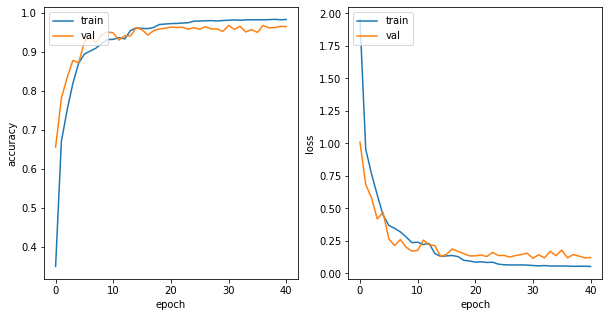

In [46]:
plot_history(vgg19_history)

In [47]:
vgg19_model.load_weights('../working/model.weights.best.hdf5')

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = vgg19_model.predict(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 5400 images belonging to 10 classes.
Accuracy: 0.967037037037037
Global F2 Score: 0.967037037037037


,Precision,Recall,F-Score,Support
AnnualCrop,0.977113,0.925000,0.950342,600.0
Forest,0.970874,1.000000,0.985222,600.0
HerbaceousVegetation,0.985989,0.938333,0.961571,600.0
Highway,0.979466,0.954000,0.966565,500.0
Industrial,0.975309,0.948000,0.961460,500.0
Pasture,0.967742,0.975000,0.971357,400.0
PermanentCrop,0.890710,0.978000,0.932316,500.0
Residential,0.947785,0.998333,0.972403,600.0
River,0.980040,0.982000,0.981019,500.0
SeaLake,0.998291,0.973333,0.985654,600.0


In [48]:
conf_mat

,AnnualCrop,Forest,HerbaceousVegetation,Highway,Industrial,Pasture,PermanentCrop,Residential,River,SeaLake
AnnualCrop,555,4,0,2,0,9,29,0,0,1
Forest,0,600,0,0,0,0,0,0,0,0
HerbaceousVegetation,0,5,563,0,0,4,24,4,0,0
Highway,2,0,1,477,5,0,5,2,8,0
Industrial,0,0,0,0,474,0,0,26,0,0
Pasture,0,3,4,0,0,390,2,0,1,0
PermanentCrop,3,0,1,1,5,0,489,1,0,0
Residential,0,0,0,0,1,0,0,599,0,0
River,1,0,0,7,1,0,0,0,491,0
SeaLake,7,6,2,0,0,0,0,0,1,584


In [49]:
# Save the model and the weights
vgg19_model.save('../working/vgg19_eurosat.h5')

In [50]:
# Saving the result
save_result('VGG19', vgg19_history)

In [3]:
def plot_graph(acc, val_acc, loss, val_loss):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc)
    plt.plot(val_acc)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(loss)
    plt.plot(val_loss)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.show();

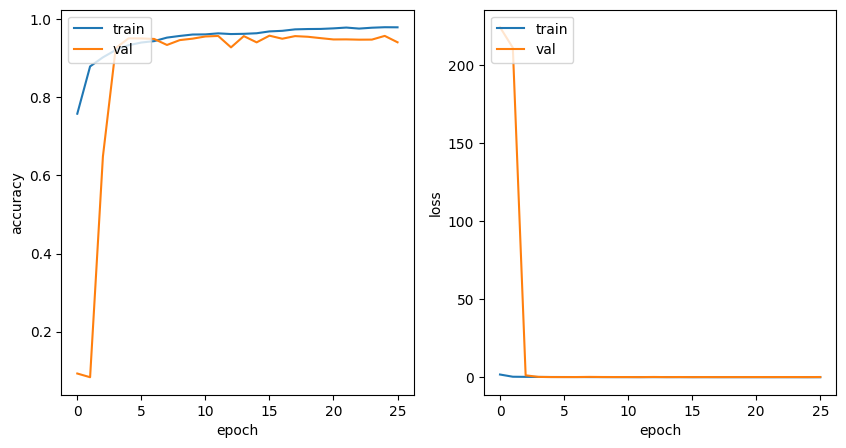

In [14]:
acc_ResNet50_np = np.load('/home/priyam/Documents/mini project final/resnet50/acc_ResNet50.npy', allow_pickle=True)
val_acc_ResNet50_np = np.load('/home/priyam/Documents/mini project final/resnet50/val_acc_ResNet50.npy', allow_pickle=True)
loss_ResNet50_np = np.load('/home/priyam/Documents/mini project final/resnet50/loss_ResNet50.npy', allow_pickle=True)
val_loss_ResNet50_np = np.load('/home/priyam/Documents/mini project final/resnet50/val_loss_ResNet50.npy', allow_pickle=True)

acc_ResNet50 = acc_ResNet50_np.tolist()
val_acc_ResNet50 = val_acc_ResNet50_np.tolist()
loss_ResNet50 = loss_ResNet50_np.tolist()
val_loss_ResNet50 = val_loss_ResNet50_np.tolist()

plot_graph(acc_ResNet50, val_acc_ResNet50, loss_ResNet50, val_loss_ResNet50)

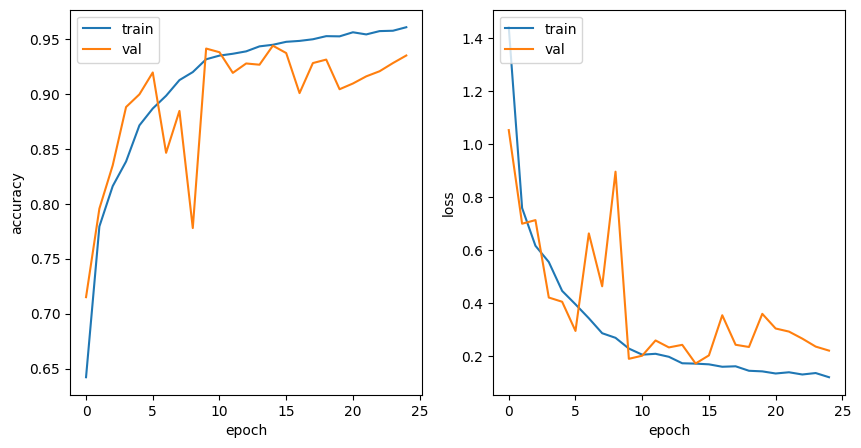

In [16]:
acc_ResNet50v2_np = np.load('/home/priyam/Documents/mini project final/resnet50v2/acc_ResNet50v2.npy', allow_pickle=True)
val_acc_ResNet50v2_np = np.load('/home/priyam/Documents/mini project final/resnet50v2/val_acc_ResNet50v2.npy', allow_pickle=True)
loss_ResNet50v2_np = np.load('/home/priyam/Documents/mini project final/resnet50v2/loss_ResNet50v2.npy', allow_pickle=True)
val_loss_ResNet50v2_np = np.load('/home/priyam/Documents/mini project final/resnet50v2/val_loss_ResNet50v2.npy', allow_pickle=True)

acc_ResNet50v2 = acc_ResNet50v2_np.tolist()
val_acc_ResNet50v2 = val_acc_ResNet50v2_np.tolist()
loss_ResNet50v2 = loss_ResNet50v2_np.tolist()
val_loss_ResNet50v2 = val_loss_ResNet50v2_np.tolist()

plot_graph(acc_ResNet50v2, val_acc_ResNet50v2, loss_ResNet50v2, val_loss_ResNet50v2)

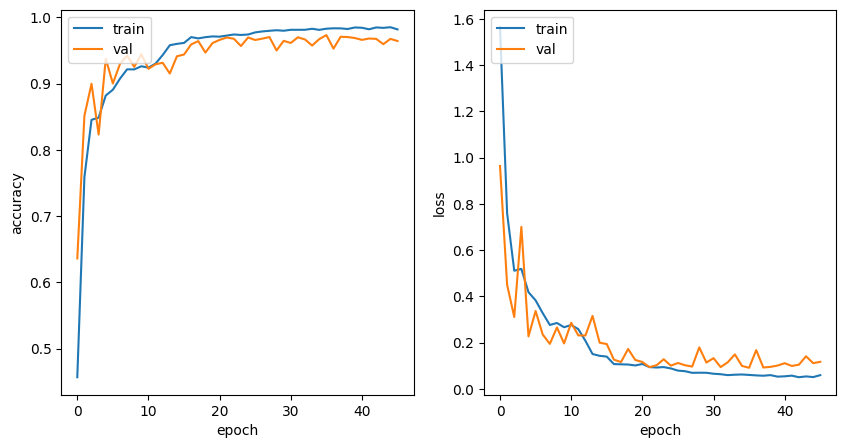

In [10]:
acc_vgg16_np = np.load('/home/priyam/Documents/mini project final/vgg16/acc_VGG16.npy', allow_pickle=True)
val_acc_vgg16_np = np.load('/home/priyam/Documents/mini project final/vgg16/val_acc_VGG16.npy', allow_pickle=True)
loss_vgg16_np = np.load('/home/priyam/Documents/mini project final/vgg16/loss_VGG16.npy', allow_pickle=True)
val_loss_vgg16_np = np.load('/home/priyam/Documents/mini project final/vgg16/val_loss_VGG16.npy', allow_pickle=True)

acc_vgg16 = acc_vgg16_np.tolist()
val_acc_vgg16 = val_acc_vgg16_np.tolist()
loss_vgg16 = loss_vgg16_np.tolist()
val_loss_vgg16 = val_loss_vgg16_np.tolist()

plot_graph(acc_vgg16, val_acc_vgg16, loss_vgg16, val_loss_vgg16)

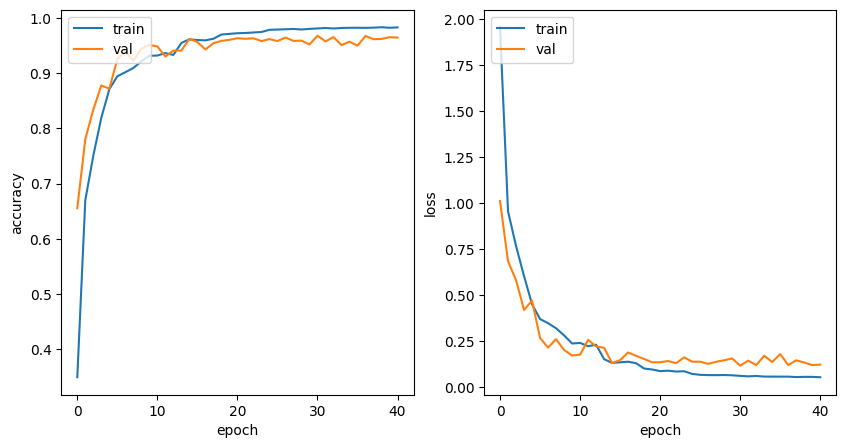

In [11]:
acc_vgg19_np = np.load('/home/priyam/Documents/mini project final/vgg19/acc_VGG19.npy', allow_pickle=True)
val_acc_vgg19_np = np.load('/home/priyam/Documents/mini project final/vgg19/val_acc_VGG19.npy', allow_pickle=True)
loss_vgg19_np = np.load('/home/priyam/Documents/mini project final/vgg19/loss_VGG19.npy', allow_pickle=True)
val_loss_vgg19_np = np.load('/home/priyam/Documents/mini project final/vgg19/val_loss_VGG19.npy', allow_pickle=True)

acc_vgg19 = acc_vgg19_np.tolist()
val_acc_vgg19 = val_acc_vgg19_np.tolist()
loss_vgg19 = loss_vgg19_np.tolist()
val_loss_vgg19 = val_loss_vgg19_np.tolist()

plot_graph(acc_vgg19, val_acc_vgg19, loss_vgg19, val_loss_vgg19)

In [24]:
def plot_graph_multiple(acc_resnet50, loss_resnet50, acc_resnet50v2, loss_resnet50v2, acc_vgg16, loss_vgg16, acc_vgg19, loss_vgg19):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc_resnet50)
    plt.plot(acc_resnet50v2)
    plt.plot(acc_vgg16)
    plt.plot(acc_vgg19)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['accuracy_ResNet50', 'accuracy_ResNet50v2', 'accuracy_vgg16', 'accuracy_vgg19'], loc='lower right')
    
    plt.subplot(1, 2, 2)
    plt.plot(loss_resnet50)
    plt.plot(loss_resnet50v2)
    plt.plot(loss_vgg16)
    plt.plot(loss_vgg19)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['loss_ResNet50', 'loss_ResNet50v2', 'loss_vgg16', 'loss_vgg19'], loc='upper right')
    
    plt.show();

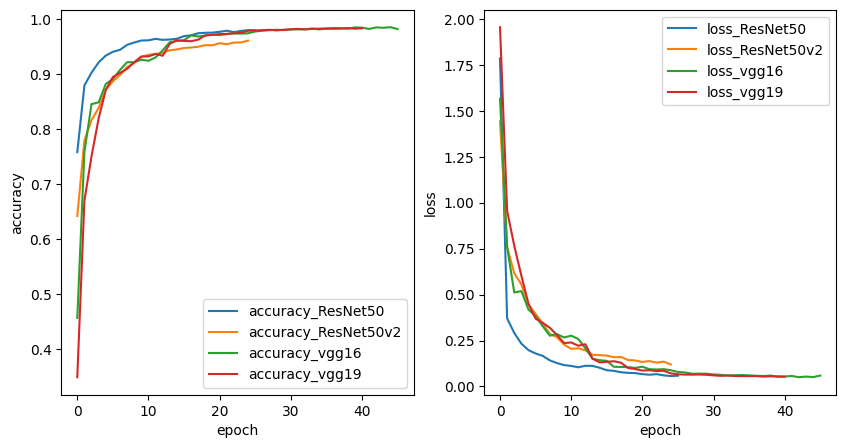

In [25]:
plot_graph_multiple(acc_ResNet50, loss_ResNet50, acc_ResNet50v2, loss_ResNet50v2, acc_vgg16, loss_vgg16, acc_vgg19, loss_vgg19)

In [2]:
from keras.models import load_model
from tensorflow.keras.utils import load_img
import numpy as np

2022-12-23 00:12:54.116703: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-23 00:13:35.779223: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-23 00:13:35.779241: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-23 00:14:19.073125: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

In [3]:
data = np.load('class_indices.npy', allow_pickle=True)
l = np.array(data)
l2 = l.tolist()
# print(type(l2))
labels = [[value, key] for key, value in l2.items()]

In [4]:
resnet50_model = load_model('./resnet50/ResNet50_eurosat.h5')
resnet50v2_model = load_model('./resnet50v2/ResNet50V2_eurosat.h5')
vgg16_model = load_model('./vgg16/vgg16_eurosat.h5')
vgg19_model = load_model('./vgg19/vgg19_eurosat.h5')

2022-12-23 00:15:22.715065: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-23 00:15:22.715106: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-23 00:15:22.715123: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (priyam): /proc/driver/nvidia/version does not exist
2022-12-23 00:15:22.796599: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-23 00:15:25.026219: W tensorflow/tsl/framework/cpu_allocator_impl.cc:

In [5]:
image = load_img('./Highway_6.jpg', target_size=(64, 64))
img = np.array(image)
img = img / 255.0
img = img.reshape(1,64,64,3)

In [6]:
predictions = resnet50_model.predict(img)
predicted_classes = np.argmax(np.rint(predictions), axis=1)
no, name = labels[predicted_classes[0]]
print(name)

1/1 [==============================] - 8s 8s/step
Highway


In [16]:
predictions = resnet50v2_model.predict(img)
predicted_classes = np.argmax(np.rint(predictions), axis=1)
no, name = labels[predicted_classes[0]]
print(name)

1/1 [==============================] - 1s 884ms/step
Highway


In [17]:
predictions = vgg16_model.predict(img)
predicted_classes = np.argmax(np.rint(predictions), axis=1)
no, name = labels[predicted_classes[0]]
print(name)

1/1 [==============================] - 0s 173ms/step
Highway


In [18]:
predictions = vgg19_model.predict(img)
predicted_classes = np.argmax(np.rint(predictions), axis=1)
no, name = labels[predicted_classes[0]]
print(name)

1/1 [==============================] - 0s 208ms/step
Highway
